In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.float_format = '{:.2f}'.format

In [135]:
file_url = 'https://raw.githubusercontent.com/Ruinenhaft/Project_space_titanic/main/data/train.csv'

In [136]:
df_raw = pd.read_csv(file_url)

In [138]:
#- PassengerId : 승객 고유 ID. gggg-pp 형태로 gggg는 그룹, pp는 그룹 내 번호. 그룹이 같으면 가족인 경우가 많음
#- HomePlanet : 고향 행성
#- CryoSleep : 냉동수면 상태 여부. 냉동수면 상태인 탑승객은 객실에 갇혀있음
#- Cabin : 객실 번호. deck/num/side 형태로 side는 P(Port) 혹은 S(Starboard)
#- Destination : 목적 행성
#- Age : 나이
#- VIP : VIP 서비스 신청했는지 여부
#- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck : 우주선 내 있는 해당 편의시설에 지불한 금액
#- Name : 이름과 성
#- Transported : 다른 차원으로 전이됐는지 여부. target

In [139]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [129]:
# HomePlanet        / Europa
#                   / Mars
#                   / Earth
#                   / 내림차순으로 생존률과 상관관계가 보이고, 소비량에서도 차이를 보임
# CryoSleep         / 냉동 수면 상태일때 생존여부와 매우 큰 관계가 보임.
# Cabin             / deck, side를 나눠서 유도변수 활용할것인지
# Destination       / 55 Cancri e
#                   / TRAPPIST-1e
#                   / PSO J318.5-22
#                   / 내림차순으로 나이, 소비량에 차이가 보임.
# Age               / 나이대별 소비패턴과 대조하여 예측할 것인지.
# VIP               / VIP여부와 소비패턴은 연관성이 커보이나 생존여부와는 큰 관계가 없어보임.
# RoomService       / 5개 컬럼 통합 해서 사용하기 전에 나이대별 소비패턴으로 활용하여 결측치 채울것인지
# FoodCourt         / 통합
# ShoppingMall      / 통합
# Spa               / 통합
# VRDeck            / 통합
# Name              / 컬럼 삭제.
# 
#
# RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, 나이를 제외한 부분은 데이터를 합성하여 하나의 column으로 변환.
# 아웃라이어 값이 존재하므로 스케일링 처리 필요.
# 아웃라이어 추출도 시각화 하여 근거로 제시해볼것.
# vip여부와 냉동수면상태의 관계 확인필요, 소비량과 생존률의 관계성은 크지 않음.
# 연령대별 냉동수면상태의 관계 확인필요.

In [130]:
df_raw.isna().sum()/len(df_raw)

PassengerId    0.00
HomePlanet     0.02
CryoSleep      0.02
Cabin          0.02
Destination    0.02
Age            0.02
VIP            0.02
RoomService    0.02
FoodCourt      0.02
ShoppingMall   0.02
Spa            0.02
VRDeck         0.02
Name           0.02
Transported    0.00
dtype: float64

In [140]:
df_raw.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


In [141]:
df_raw.describe(include='O')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


Text(0.5, 0, 'Age')

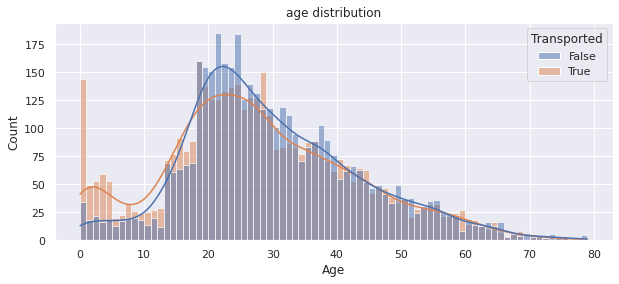

In [143]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df_raw, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('age distribution')
plt.xlabel('Age')

In [144]:
# 0~18세 까지는 이동된 사람 비중이 많다.
# 18 ~ 25세 까지는 이동되지 못한 사람 비중이 많다.
# 25세 이후는 대체로 비슷하다.
# 성인인지 아닌지로 나눠서 age 유도 변수를 생성해주는것은 어떨지

In [145]:
pd.set_option('display.max_rows', None)
df_raw.groupby('Age').mean() # 0~10살, 11~20살, 이런식으로 합쳐서 통계를 내야 볼만 할것같다.

,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Age,,,,,,
0.00,0.00,0.00,0.00,0.00,0.00,0.81
1.00,0.00,0.00,0.00,0.00,0.00,0.73
2.00,0.00,0.00,0.00,0.00,0.00,0.71
3.00,0.00,0.00,0.00,0.00,0.00,0.79
4.00,0.00,0.00,0.00,0.00,0.00,0.75
5.00,0.00,0.00,0.00,0.00,0.00,0.61
6.00,0.00,0.00,0.00,0.00,0.00,0.57
7.00,0.00,0.00,0.00,0.00,0.00,0.62
8.00,0.00,0.00,0.00,0.00,0.00,0.57


In [146]:
df_raw.groupby('Destination').mean() # 목적지별 평균치.

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
Destination,,,,,,,
55 Cancri e,29.31,192.82,888.09,157.70,480.40,508.56,0.61
PSO J318.5-22,27.53,90.60,122.19,113.29,118.00,140.13,0.50
TRAPPIST-1e,28.82,252.95,375.92,187.46,283.98,267.79,0.47


In [147]:
df_raw.groupby('CryoSleep').mean() # 냉동 수면 상태일때 생존여부와 매우 큰 관계가 보임.

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
CryoSleep,,,,,,,
False,29.65,350.15,713.00,270.59,486.09,475.72,0.33
True,27.41,0.00,0.00,0.00,0.00,0.00,0.82


In [148]:
df_raw.groupby('VIP').mean() # VIP여부와 소비패턴은 연관성이 커보이나 생존여부와는 음의선형관계를 보임.

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
VIP,,,,,,,
False,28.64,217.22,426.34,173.88,301.71,282.72,0.51
True,37.45,473.62,1811.39,247.73,760.71,1234.86,0.38


In [149]:
df_raw.groupby('HomePlanet').mean() # VIP여부와 소비패턴은 연관성이 커보이나 생존여부와는 음의선형관계를 보임.

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
HomePlanet,,,,,,,
Earth,26.07,136.94,137.23,133.87,142.78,138.13,0.42
Europa,34.42,145.23,1503.21,151.13,848.06,875.77,0.66
Mars,29.30,552.90,54.36,308.45,110.22,47.44,0.52


In [150]:
corr = df_raw.corr(method='pearson')
print(corr)

               Age  RoomService  FoodCourt  ShoppingMall   Spa  VRDeck  \
Age           1.00         0.07       0.13          0.03  0.12    0.10   
RoomService   0.07         1.00      -0.02          0.05  0.01   -0.02   
FoodCourt     0.13        -0.02       1.00         -0.01  0.22    0.23   
ShoppingMall  0.03         0.05      -0.01          1.00  0.01   -0.01   
Spa           0.12         0.01       0.22          0.01  1.00    0.15   
VRDeck        0.10        -0.02       0.23         -0.01  0.15    1.00   
Transported  -0.08        -0.24       0.05          0.01 -0.22   -0.21   

              Transported  
Age                 -0.08  
RoomService         -0.24  
FoodCourt            0.05  
ShoppingMall         0.01  
Spa                 -0.22  
VRDeck              -0.21  
Transported          1.00  


In [151]:
# vip 여부별 수치 확인하고싶음.
df_raw['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [152]:
df_raw['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [153]:
df_raw['Transported'].value_counts()

True     4378
False    4315
Name: Transported, dtype: int64

In [154]:
# 대충 데이터 분석 끝.
# 전처리 시작
# 전처리는 결측치 중위값으로 처리
# 컬럼명 소문자 통일
# object 타입 컬럼 처리방식 도출해보기.

In [155]:
df_raw.columns = df_raw.columns.str.lower() # 컬럼명 소문자 통일.

In [156]:
df_raw.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [157]:
df_raw['cryosleep'] = df_raw['cryosleep'].fillna(0)
df_raw['vip'] = df_raw['vip'].fillna(0)
df_raw['cabin'] = df_raw['cabin'].fillna(df_raw['cabin'].mode()[0])
df_raw['homeplanet'] = df_raw['homeplanet'].fillna(df_raw['homeplanet'].mode()[0])
df_raw['destination'] = df_raw['destination'].fillna(df_raw['destination'].mode()[0])
df_raw['shoppingmall'] = df_raw['shoppingmall'].fillna(df_raw['shoppingmall'].median())
df_raw['vrdeck'] = df_raw['vrdeck'].fillna(df_raw['vrdeck'].median())
df_raw['foodcourt'] = df_raw['foodcourt'].fillna(df_raw['foodcourt'].median())
df_raw['spa'] = df_raw['spa'].fillna(df_raw['spa'].median())
df_raw['roomservice'] = df_raw['roomservice'].fillna(df_raw['roomservice'].median())
df_raw['age'] = df_raw['age'].fillna(df_raw['age'].median())

In [158]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   passengerid   8693 non-null   object 
 1   homeplanet    8693 non-null   object 
 2   cryosleep     8693 non-null   object 
 3   cabin         8693 non-null   object 
 4   destination   8693 non-null   object 
 5   age           8693 non-null   float64
 6   vip           8693 non-null   object 
 7   roomservice   8693 non-null   float64
 8   foodcourt     8693 non-null   float64
 9   shoppingmall  8693 non-null   float64
 10  spa           8693 non-null   float64
 11  vrdeck        8693 non-null   float64
 12  name          8493 non-null   object 
 13  transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [159]:
# 남은 결측치 name, name은 drop하고 passengerid 활용하여 동료로 탑승한 여부를 새 탭으로 지정하여 1, 0값으로 도출.
# passengerid 앞 네자리를 잘라서 전체값과 비교하여 같은 값이 있으면 1. 아니면 0 출력.
def passengerid_split(value):
    return value.split('_')[0]

In [160]:
df_train1 = df_raw.copy() # 데이터 카피

In [161]:
df_train1['id_coop'] = df_train1['passengerid'].apply(passengerid_split) # 동료여부를 확인하기 위한 컬럼인덱스 확보

In [162]:
df_train1.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,id_coop
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True,0004


In [163]:
coop_map = {}
for number in df_train1['id_coop']:
    try : coop_map[number] += 1 # for문을 통해 list의 요소를 하나씩 꺼내여, coop_cnt 딕셔너리에 넣는다.
    except : coop_map[number] = 1 # 이때 딕셔너리에 이미 존재하는 key값이라면 , try문 실행, value +1 , 없으면 expept 값 1.
print(coop_map)

{'0001': 1, '0002': 1, '0003': 2, '0004': 1, '0005': 1, '0006': 2, '0007': 1, '0008': 3, '0009': 1, '0010': 1, '0011': 1, '0012': 1, '0014': 1, '0015': 1, '0016': 1, '0017': 2, '0020': 6, '0022': 1, '0024': 1, '0025': 1, '0026': 1, '0028': 1, '0030': 1, '0031': 3, '0034': 1, '0035': 1, '0036': 1, '0038': 1, '0039': 1, '0041': 1, '0043': 1, '0044': 3, '0045': 2, '0050': 1, '0051': 1, '0052': 1, '0053': 1, '0056': 3, '0058': 1, '0061': 1, '0062': 1, '0064': 2, '0066': 1, '0067': 3, '0068': 1, '0069': 1, '0070': 1, '0071': 1, '0072': 1, '0073': 1, '0074': 1, '0076': 1, '0077': 1, '0078': 1, '0081': 1, '0082': 3, '0084': 1, '0085': 1, '0086': 1, '0088': 1, '0090': 1, '0091': 2, '0092': 3, '0097': 1, '0098': 2, '0099': 2, '0101': 1, '0102': 1, '0103': 3, '0105': 1, '0107': 1, '0108': 3, '0110': 4, '0111': 1, '0112': 1, '0113': 1, '0114': 1, '0115': 1, '0116': 1, '0119': 2, '0120': 1, '0122': 1, '0123': 1, '0126': 1, '0127': 1, '0128': 2, '0129': 1, '0133': 2, '0134': 1, '0136': 1, '0138': 2

In [164]:
# coop_map에 매칭되는 id_coop을 찾아 값을 넣어준다.
df_train1['id_coop'] = df_train1['id_coop'].map(coop_map)
df_train1.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,name,transported,id_coop
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True,1


In [165]:
# 가족관계는 동료값으로 추출했으니 배제
df_train1.drop('name', axis = 1, inplace=True)
df_train1.head()

,passengerid,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,id_coop
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,False,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,True,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,False,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,False,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,True,1


In [166]:
# id 추출했으니 passengerid 배제
df_train1.drop('passengerid', axis = 1, inplace=True)
df_train1.head()

,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,id_coop
0,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,False,1
1,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,True,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,False,2
3,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,False,2
4,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,True,1


In [167]:
# cabin 배치칸 몇번칸인지, 안쪽인지 밖쪽인지 나누고
# homeplanet, destination 더미화
# cryosleep, vip, transported True 1, False 0 분리.

In [168]:
cab = df_train1["cabin"].apply(lambda x: x.split("/"))

df_train1["c_1"] = cab.apply(lambda x: x[0])
df_train1["c_2"] = cab.apply(lambda x: int(x[1]))
df_train1["c_3"] = cab.apply(lambda x: x[2])

In [169]:
df_train1 = pd.get_dummies(df_train1, columns = ['c_1', 'c_3'])
df_train1.head()

,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,...,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,c_3_P,c_3_S
0,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0,0,1,0
1,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,...,0,0,0,0,0,1,0,0,0,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,...,1,0,0,0,0,0,0,0,0,1
3,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,...,1,0,0,0,0,0,0,0,0,1
4,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,...,0,0,0,0,0,1,0,0,0,1


In [170]:
df_train1.head()

,homeplanet,cryosleep,cabin,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,...,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,c_3_P,c_3_S
0,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0,0,1,0
1,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,...,0,0,0,0,0,1,0,0,0,1
2,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,...,1,0,0,0,0,0,0,0,0,1
3,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,...,1,0,0,0,0,0,0,0,0,1
4,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,...,0,0,0,0,0,1,0,0,0,1


In [171]:
# cabin 삭제
df_train1.drop('cabin', axis = 1, inplace=True)
df_train1.head()

,homeplanet,cryosleep,destination,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,...,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,c_3_P,c_3_S
0,Europa,False,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,...,0,1,0,0,0,0,0,0,1,0
1,Earth,False,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,...,0,0,0,0,0,1,0,0,0,1
2,Europa,False,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,...,1,0,0,0,0,0,0,0,0,1
3,Europa,False,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,...,1,0,0,0,0,0,0,0,0,1
4,Earth,False,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,...,0,0,0,0,0,1,0,0,0,1


In [172]:
df_train1 = pd.get_dummies(df_train1, columns = ['homeplanet', 'destination'])
df_train1.head()

,cryosleep,age,vip,roomservice,foodcourt,shoppingmall,spa,vrdeck,transported,id_coop,...,c_1_G,c_1_T,c_3_P,c_3_S,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e
0,False,39.00,False,0.00,0.00,0.00,0.00,0.00,False,1,...,0,0,1,0,0,1,0,0,0,1
1,False,24.00,False,109.00,9.00,25.00,549.00,44.00,True,1,...,0,0,0,1,1,0,0,0,0,1
2,False,58.00,True,43.00,3576.00,0.00,6715.00,49.00,False,2,...,0,0,0,1,0,1,0,0,0,1
3,False,33.00,False,0.00,1283.00,371.00,3329.00,193.00,False,2,...,0,0,0,1,0,1,0,0,0,1
4,False,16.00,False,303.00,70.00,151.00,565.00,2.00,True,1,...,0,0,0,1,1,0,0,0,0,1


In [173]:
df_train1 = pd.get_dummies(df_train1, columns = ['cryosleep', 'vip', 'transported'], drop_first=True)
df_train1.head()

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,id_coop,c_2,c_1_A,c_1_B,...,c_3_S,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True
0,39.00,0.00,0.00,0.00,0.00,0.00,1,0,0,1,...,0,0,1,0,0,0,1,0,0,0
1,24.00,109.00,9.00,25.00,549.00,44.00,1,0,0,0,...,1,1,0,0,0,0,1,0,0,1
2,58.00,43.00,3576.00,0.00,6715.00,49.00,2,0,1,0,...,1,0,1,0,0,0,1,0,1,0
3,33.00,0.00,1283.00,371.00,3329.00,193.00,2,0,1,0,...,1,0,1,0,0,0,1,0,0,0
4,16.00,303.00,70.00,151.00,565.00,2.00,1,1,0,0,...,1,1,0,0,0,0,1,0,0,1


In [174]:
df_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   age                        8693 non-null   float64
 1   roomservice                8693 non-null   float64
 2   foodcourt                  8693 non-null   float64
 3   shoppingmall               8693 non-null   float64
 4   spa                        8693 non-null   float64
 5   vrdeck                     8693 non-null   float64
 6   id_coop                    8693 non-null   int64  
 7   c_2                        8693 non-null   int64  
 8   c_1_A                      8693 non-null   uint8  
 9   c_1_B                      8693 non-null   uint8  
 10  c_1_C                      8693 non-null   uint8  
 11  c_1_D                      8693 non-null   uint8  
 12  c_1_E                      8693 non-null   uint8  
 13  c_1_F                      8693 non-null   uint8

In [175]:
df_train1.corr()

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,id_coop,c_2,c_1_A,c_1_B,...,c_3_S,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True
age,1.00,0.07,0.13,0.03,0.12,0.10,-0.18,-0.13,0.07,0.10,...,0.01,-0.20,0.22,0.02,0.02,-0.03,0.00,-0.07,0.09,-0.07
roomservice,0.07,1.00,-0.02,0.05,0.01,-0.02,-0.04,-0.01,-0.02,-0.06,...,-0.01,-0.14,-0.07,0.25,-0.02,-0.06,0.06,-0.24,0.06,-0.24
foodcourt,0.13,-0.02,1.00,-0.01,0.22,0.22,0.03,-0.18,0.12,0.16,...,0.02,-0.22,0.37,-0.12,0.13,-0.07,-0.08,-0.21,0.13,0.05
shoppingmall,0.03,0.05,-0.01,1.00,0.01,-0.01,-0.04,0.00,-0.02,-0.01,...,-0.02,-0.07,-0.02,0.11,-0.01,-0.03,0.03,-0.21,0.02,0.01
spa,0.12,0.01,0.22,0.01,1.00,0.15,0.02,-0.13,0.06,0.11,...,0.01,-0.16,0.27,-0.09,0.08,-0.05,-0.03,-0.20,0.06,-0.22
vrdeck,0.10,-0.02,0.22,-0.01,0.15,1.00,0.01,-0.14,0.10,0.12,...,-0.01,-0.15,0.28,-0.11,0.09,-0.04,-0.05,-0.19,0.12,-0.20
id_coop,-0.18,-0.04,0.03,-0.04,0.02,0.01,1.00,-0.05,0.04,0.08,...,0.02,-0.10,0.13,-0.02,0.06,-0.06,-0.02,0.08,0.00,0.08
c_2,-0.13,-0.01,-0.18,0.00,-0.13,-0.14,-0.05,1.00,-0.19,-0.27,...,-0.03,0.37,-0.48,0.06,-0.14,0.10,0.06,-0.04,-0.10,-0.04
c_1_A,0.07,-0.02,0.12,-0.02,0.06,0.10,0.04,-0.19,1.00,-0.05,...,0.01,-0.19,0.30,-0.09,0.09,-0.05,-0.05,-0.03,0.13,-0.00
c_1_B,0.10,-0.06,0.16,-0.01,0.11,0.12,0.08,-0.27,-0.05,1.00,...,0.02,-0.34,0.54,-0.16,0.17,-0.10,-0.09,0.12,0.07,0.14


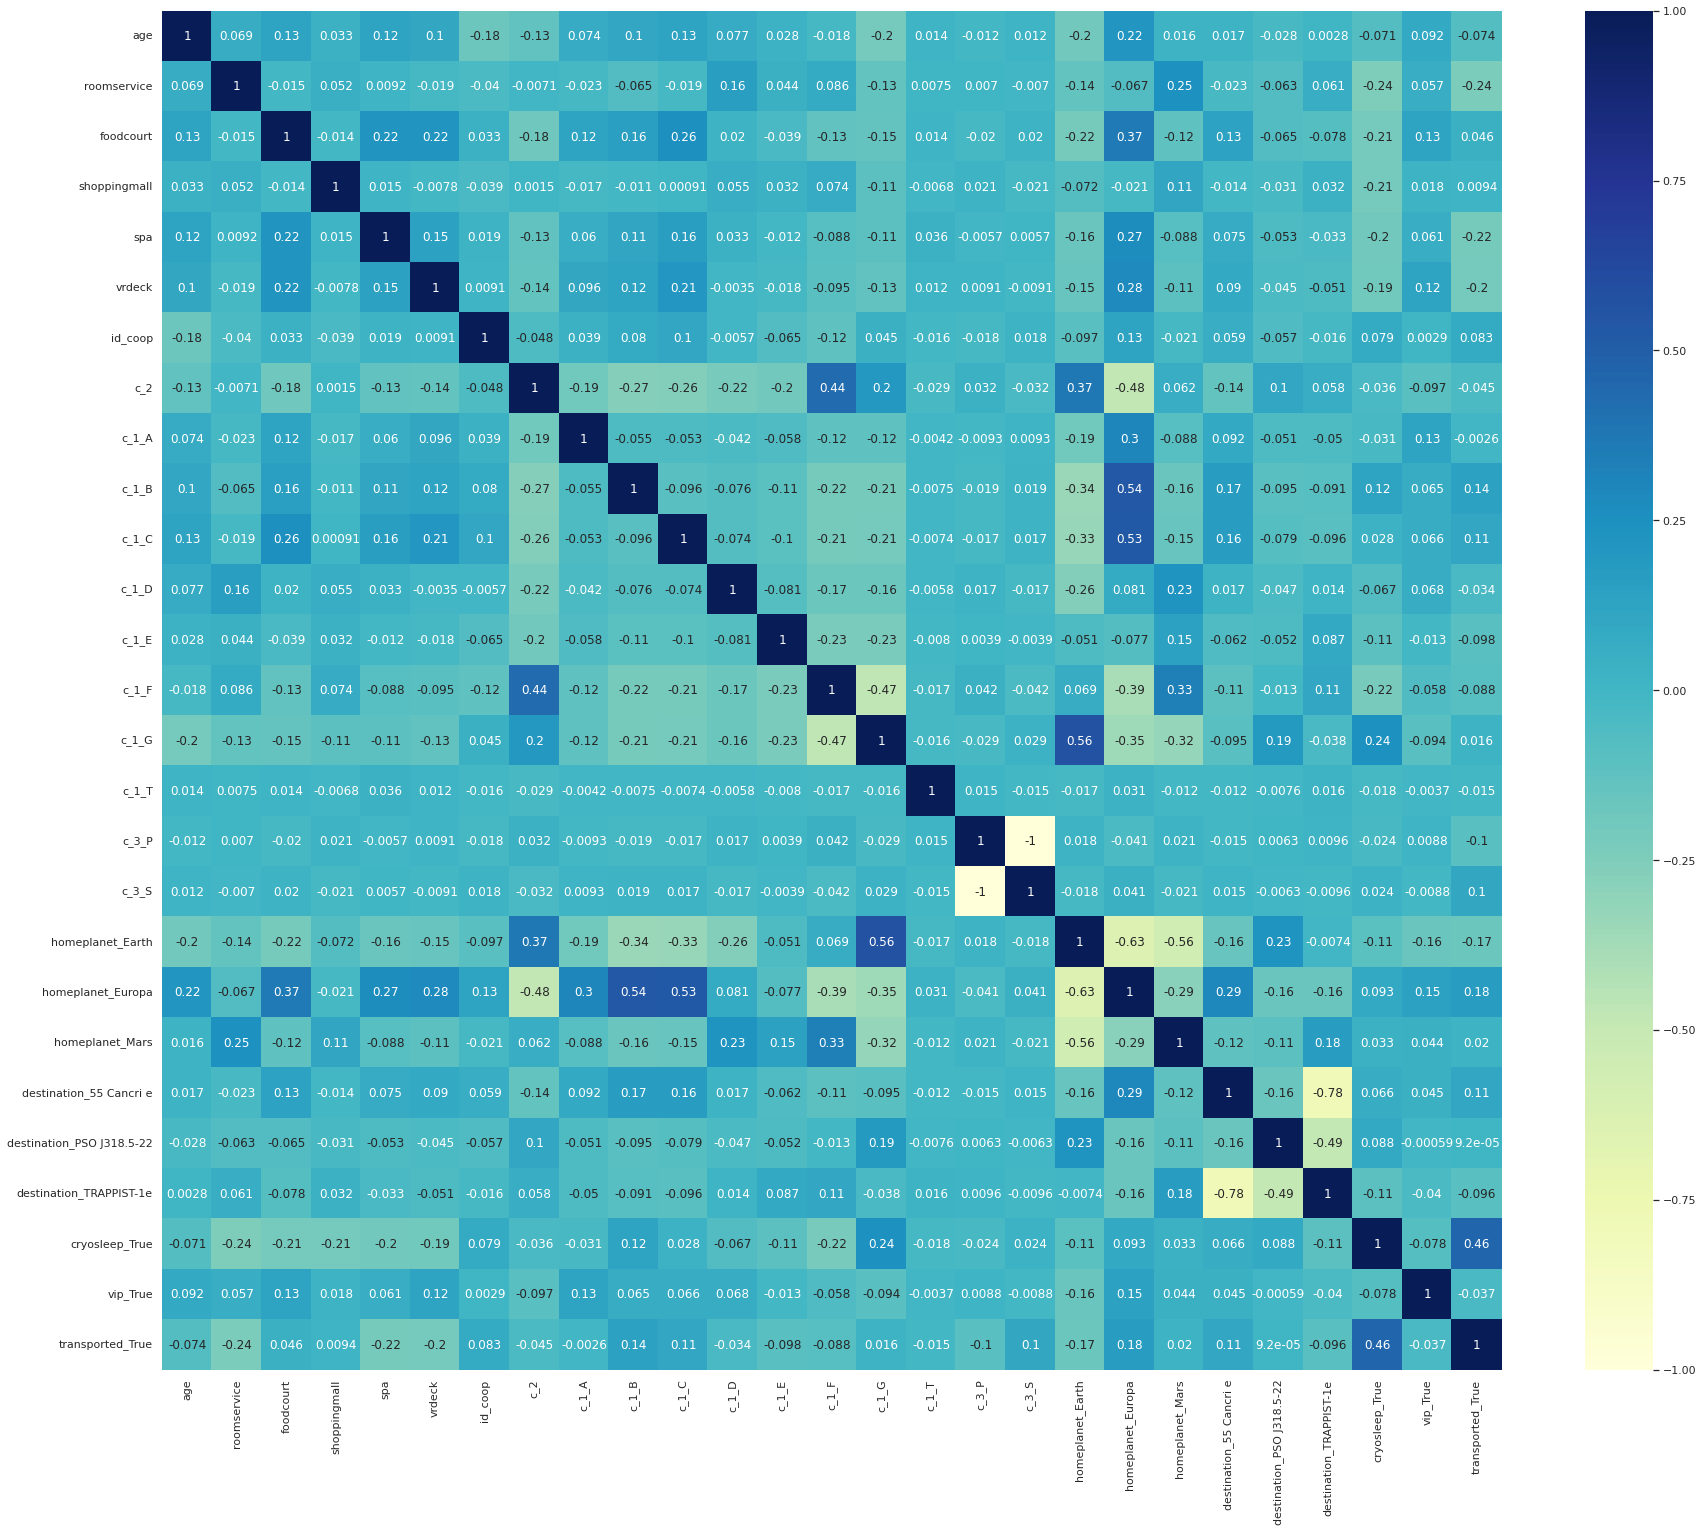

In [176]:
# 상관관계 확인
df_train1_corr = df_train1.corr()
plt.figure(figsize=(30, 25))
sns.set(font_scale=1)
train_obj_heat = sns.heatmap(df_train1_corr, annot=True, fmt='.2g', cmap='YlGnBu', vmin=-1, vmax=1)
plt.show(train_obj_heat)

In [177]:
# 최대한 모든 지표를 살려서 출력했습니다.
# name은 drop하고
# passengerid 활용하여 동료로 탑승한 수 생성                          -> id_coop
# cabin 배치칸 몇번칸인지, 안쪽인지 밖쪽인지 나누고 더미              -> c_1, c_2, c_3 /로 나눈 순서대로
# homeplanet, destination 더미화
# cryosleep, vip, transported True 1, False 0 분리.

# 동면 정도면 0.46으로 연관성을 가지고
# 두번 째로 0.18 Europa 출신이냐.
# Europa 출신 B, C 칸에 주로 탑승하고 있었다.

In [178]:
# 결측치는 중앙값으로 처리.
# 최빈값 처리.
# 여기서 더 진행한다면..

Text(0.5, 0, 'age')

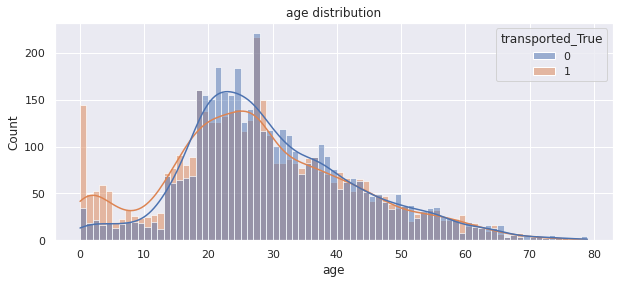

In [179]:
# 나이
plt.figure(figsize=(10, 4))
sns.histplot(data=df_train1, x='age', hue='transported_True', binwidth=1, kde=True)
plt.title('age distribution')
plt.xlabel('age')

In [180]:
# 0~18세 까지는 이동된 사람 비중이 많다.
# 18 ~ 25세 까지는 이동되지 못한 사람 비중이 많다.
# 25세 이후는 대체로 비슷하다.
# 성인인지 아닌지로 나눠서 age 유도 변수를 생성해주는것은 어떨지

In [181]:
# 나이가 18세 이하면 1, 18세 이상이면 0.
df_train1['age_adult'] = np.nan
df_train1.loc[df_train1['age'] < 18, 'age_adult'] = 0
df_train1.loc[df_train1['age'] >= 18, 'age_adult'] = 1
df_train1.head()

,age,roomservice,foodcourt,shoppingmall,spa,vrdeck,id_coop,c_2,c_1_A,c_1_B,...,homeplanet_Earth,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult
0,39.00,0.00,0.00,0.00,0.00,0.00,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1.00
1,24.00,109.00,9.00,25.00,549.00,44.00,1,0,0,0,...,1,0,0,0,0,1,0,0,1,1.00
2,58.00,43.00,3576.00,0.00,6715.00,49.00,2,0,1,0,...,0,1,0,0,0,1,0,1,0,1.00
3,33.00,0.00,1283.00,371.00,3329.00,193.00,2,0,1,0,...,0,1,0,0,0,1,0,0,0,1.00
4,16.00,303.00,70.00,151.00,565.00,2.00,1,1,0,0,...,1,0,0,0,0,1,0,0,1,0.00


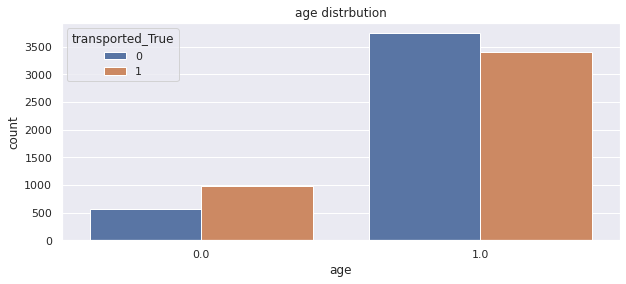

In [182]:
plt.figure(figsize=(10, 4))
sns.countplot(data = df_train1, x='age_adult', hue='transported_True')
plt.title('age distrbution')
plt.xlabel('age')
plt.show()

In [183]:
# 0, 1로 전환하여 값을 간소화, 오버피팅 방지.

In [184]:
df_train1.drop('age',axis = 1, inplace=True)

In [185]:
# 지출 토탈
df_train1['total_exp'] = df_train1[['roomservice','foodcourt','shoppingmall','spa','vrdeck']].sum(axis=1)


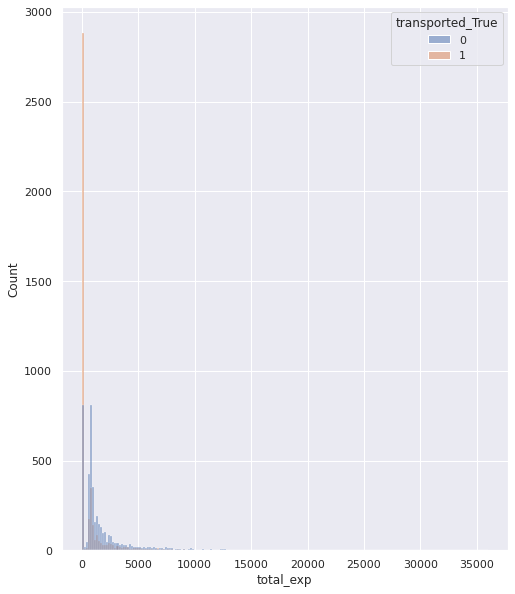

In [186]:
fig = plt.figure(figsize=(8, 10))
sns.histplot(data=df_train1, x='total_exp', hue='transported_True', bins=200)
plt.show()

In [187]:
# 지출이 0인사람의 생존확률이 높음.
# 0, 1로 나누어 특징을 간소화.
# 오버피팅 잡고, 확실한 결과물 도출.

In [188]:
df_train1['exp_binary'] = np.nan
df_train1.loc[df_train1['total_exp'] > 0, 'exp_binary'] = 1
df_train1.loc[df_train1['total_exp'] == 0, 'exp_binary'] = 0 
df_train1.head()

,roomservice,foodcourt,shoppingmall,spa,vrdeck,id_coop,c_2,c_1_A,c_1_B,c_1_C,...,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult,total_exp,exp_binary
0,0.00,0.00,0.00,0.00,0.00,1,0,0,1,0,...,0,0,0,1,0,0,0,1.00,0.00,0.00
1,109.00,9.00,25.00,549.00,44.00,1,0,0,0,0,...,0,0,0,1,0,0,1,1.00,736.00,1.00
2,43.00,3576.00,0.00,6715.00,49.00,2,0,1,0,0,...,0,0,0,1,0,1,0,1.00,10383.00,1.00
3,0.00,1283.00,371.00,3329.00,193.00,2,0,1,0,0,...,0,0,0,1,0,0,0,1.00,5176.00,1.00
4,303.00,70.00,151.00,565.00,2.00,1,1,0,0,0,...,0,0,0,1,0,0,1,0.00,1091.00,1.00


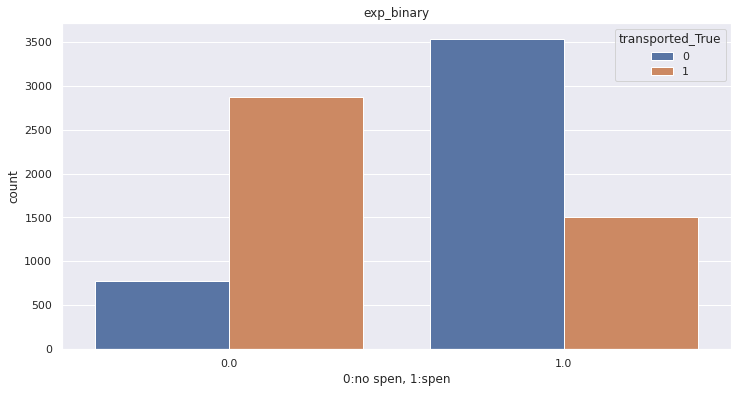

In [189]:
plt.figure(figsize=(12, 6))
sns.countplot(data = df_train1, x='exp_binary', hue='transported_True')
plt.title('exp_binary')
plt.xlabel('0:no spen, 1:spen')
plt.show()

In [190]:
df_train1.drop(['roomservice','foodcourt','shoppingmall','spa','vrdeck','total_exp'], axis=1, inplace=True)

In [191]:
df_train1.head()

,id_coop,c_2,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,...,homeplanet_Europa,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult,exp_binary
0,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1.00,0.00
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,1.00,1.00
2,2,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,1.00,1.00
3,2,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1.00,1.00
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0.00,1.00


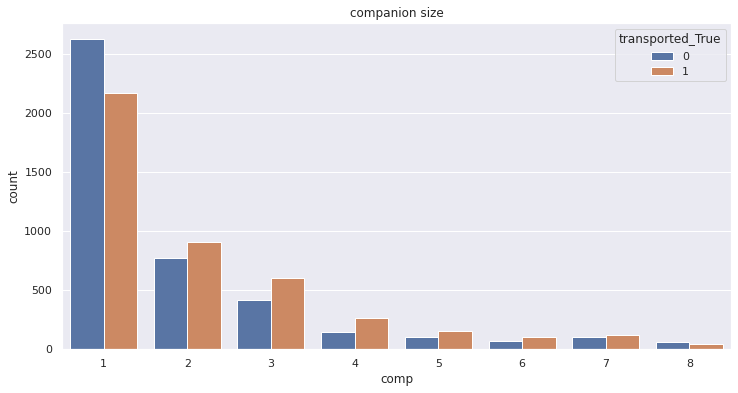

In [192]:
# 동료 규모에 따른 생존률
plt.figure(figsize=(12, 6))
sns.countplot(data=df_train1, x='id_coop', hue='transported_True')
plt.title('companion size')
plt.xlabel('comp')
plt.show()


In [193]:
# 혼자일때 생존률이 높은편, 이진화 하여
df_train1['id_coop_solo'] = np.nan
df_train1.loc[df_train1['id_coop'] > 1, 'id_coop_solo'] = 0
df_train1.loc[df_train1['id_coop'] == 1, 'id_coop_solo'] = 1 
df_train1.head()

,id_coop,c_2,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,...,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult,exp_binary,id_coop_solo
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1.00,0.00,1.00
1,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,1.00,1.00,1.00
2,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1.00,1.00,0.00
3,2,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1.00,1.00,0.00
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0.00,1.00,1.00


In [194]:
df_train1.drop('id_coop', axis=1, inplace=True)
df_train1.head()

,c_2,c_1_A,c_1_B,c_1_C,c_1_D,c_1_E,c_1_F,c_1_G,c_1_T,c_3_P,...,homeplanet_Mars,destination_55 Cancri e,destination_PSO J318.5-22,destination_TRAPPIST-1e,cryosleep_True,vip_True,transported_True,age_adult,exp_binary,id_coop_solo
0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1.00,0.00,1.00
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,1.00,1.00,1.00
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,1.00,1.00,0.00
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1.00,1.00,0.00
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0.00,1.00,1.00


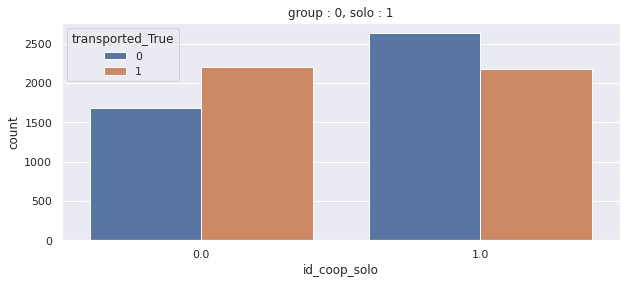

In [197]:
plt.figure(figsize=(10,4))
sns.countplot(data=df_train1, x='id_coop_solo', hue='transported_True')
plt.title('group : 0, solo : 1')
plt.show()